In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## Cross-validation of model performance

In this notebook, we wish to cross-validate our GNN model's performance. In particular, I do want to see whether the trends we observed are reproducible across different PRNGKeys.

## Load data

We start with a pickled version of our graph data.

In [2]:
# 1. Start a W&B run
# wandb.init(project='drosha-gnn', entity='ericmjl')

# 2. Save model inputs and hyperparameters
# config = wandb.config
# config.learning_rate = 0.01

# Model training here

# 3. Log metrics over time to visualize performance
# wandb.log({"loss": loss})
    

## Imports

In [3]:
from sklearn.pipeline import Pipeline

import pickle as pkl
from pyprojroot import here
from drosha_gnn.graph import to_networkx
from drosha_gnn import annotate
import pandas as pd
import janitor
import jax.numpy as np
import networkx as nx

## Read Data

### Raw Dataframe

In [4]:
df = (
    pd.read_csv("https://drosha-data.fly.dev/drosha/combined.csv?_stream=on&_sort=rowid&replicate__exact=1&_size=max")
    .join_apply(lambda row: to_networkx(row["dot_bracket"]), "graph")
)
df.head()

,rowid,miRNA,forward_mut,frac_avg,replicate,lowCounts_y,outlier_y,seq,fiveEnd,threeEnd,...,UGU,CNNC,dot_bracket,compact,hairpin_score,minimum_free_energy,ensemble_free_energy,basename,logit,graph
0,1,1,None,0.998386,1,0,0,GUACGGAGGCUGUUAGGCAGACACAAACUGUGAAGUGCUGUGGAUU...,10,-10,...,0,1,((((....((((((..((((.(((...(((((((((((((((((((...,23.822519,337.293747,-59.5,-0.440509,1,6.427601,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,2,None,0.998126,1,0,0,GUACGGAGGCUGUUAGGCAGCACUCGCUCCCACCUUGUCCUCACGG...,15,-13,...,0,1,(((((...(((((...))))).((((((.(((((.((.(((((.((...,22.298016,384.374378,-58.6,-0.421181,2,6.277715,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,3,3,None,0.997694,1,0,0,GUACGGAGGCUGUUAGGCAGACUCCUCAUGGCCUCACUUUUCCACU...,9,-9,...,0,0,....((((.((((...)))).))))......((((((((.((((((...,21.073267,273.538719,-71.7,-0.512519,3,6.070139,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,4,4,None,0.997542,1,0,0,GUACGGAGGCUGUUAGGCAGAAGCCUUGUGUUCCAGCCCGAGGCCU...,10,-8,...,0,0,(((((((((((..........)))))).(((((((((.((((((((...,18.817662,404.884757,-67.4,-0.511715,4,6.006048,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,5,5,None,0.997495,1,0,0,GUACGGAGGCUGUUAGGCAGCCACUGGCCCAUCUCUUACACAGGCU...,15,-13,...,0,1,(((((..((((((...)))))).(((.....(((((((((((...(...,22.285955,529.074249,-50.9,-0.362944,5,5.986989,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


### Nucleotide Entropy Data

In [9]:
entropy = pd.read_csv("https://drosha-data.fly.dev/drosha/entropy.csv?_labels=on&_stream=on&_sort=rowid&rowid__lte=847&_size=max")

In [6]:
entropy

,shannon_1,shannon_2,shannon_3,shannon_4,shannon_5,shannon_6,shannon_7,shannon_8,shannon_9,shannon_10,...,shannon_161,shannon_162,shannon_163,shannon_164,shannon_165,shannon_166,shannon_167,shannon_168,shannon_169,shannon_170
0,0.093327,0.132150,0.132671,0.232952,0.292199,0.097116,0.093368,0.092654,0.442830,0.650076,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.032027,0.048495,0.048561,0.071540,0.203048,0.182248,0.178692,0.202356,0.087521,0.091389,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.193411,0.217418,0.175848,0.174624,0.082767,0.115770,0.114511,0.127746,0.111877,0.057724,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.061604,0.071435,0.095937,0.171910,0.266387,0.173177,0.140964,0.220340,0.408112,0.470108,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.124070,0.137540,0.102726,0.232545,0.294623,0.135824,0.001541,0.017573,0.078687,0.080727,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.078119,0.077245,0.077338,0.202875,0.247116,0.000279,0.000042,0.003764,0.076561,0.041684,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
843,0.067294,0.067470,0.068231,0.183351,0.279651,0.001304,0.000309,0.000228,0.187805,0.273305,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
844,0.018254,0.018222,0.017389,0.030802,0.329055,0.294726,0.230599,0.116600,0.011486,0.007482,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
845,0.278459,0.301325,0.302813,0.407172,0.374801,0.144067,0.234351,0.288424,0.280608,0.465083,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [8]:
from tqdm.auto import tqdm
from drosha_gnn.data import make_graph, make_graph_matrices
from drosha_gnn.data import prep_feats, prep_adjs, feat_matrix
graphs = dict()
graph_matrices = dict()
for sample_idx in tqdm(df.index):
    graphs[sample_idx] = make_graph(sample_idx, df, entropy)
    graph_matrices[sample_idx] = make_graph_matrices(sample_idx, df, entropy)

  0%|          | 0/847 [00:00<?, ?it/s]

## Train test splits

We need different train-test splits in order to test the uncertainty in model performance.

In [66]:
from jax.random import PRNGKey, split

key = PRNGKey(99)


In [67]:
from drosha_gnn.training import train_test_split
from drosha_gnn.data import split_graph_data

In [68]:
# Just test-driving
X_train, X_test, y_train, y_test = split_graph_data(key, graph_matrices, df)
y_train.shape

(592, 1)

In [69]:
from drosha_gnn.models import AttentionEverywhereGNN

In [70]:

from drosha_gnn.models import make_model_and_params

model, params = make_model_and_params(key, AttentionEverywhereGNN, input_shape=(170, 2), num_nodes=170)

In [71]:
model(params, X_train[12])

DeviceArray([0.01067132], dtype=float32)

In [72]:
## Test-drive model
from jax import vmap
from functools import partial

vmap(partial(model, params))(X_train)

DeviceArray([[0.01066472],
             [0.01066024],
             [0.01066507],
             [0.01067   ],
             [0.01066443],
             [0.01066721],
             [0.01066985],
             [0.01067572],
             [0.01067326],
             [0.01066344],
             [0.01066225],
             [0.01066931],
             [0.01067132],
             [0.01066626],
             [0.010669  ],
             [0.01067268],
             [0.01066771],
             [0.01066755],
             [0.01066868],
             [0.01067425],
             [0.01066705],
             [0.01067764],
             [0.01066548],
             [0.01067313],
             [0.01068081],
             [0.01066615],
             [0.01067193],
             [0.01066897],
             [0.01067125],
             [0.0106646 ],
             [0.01067504],
             [0.010668  ],
             [0.01066537],
             [0.01066466],
             [0.01066877],
             [0.01067083],
             [0.01066714],
 

In [73]:
from drosha_gnn.training import fit, dmseloss, mseloss

In [74]:
losses_train, states, opt_get_params = fit(model, params, X_train, y_train)

Training Iteration:   0%|          | 0/200 [00:00<?, ?it/s]

In [75]:
# from jax.experimental.optimizers import adam
# from jax import jit, vmap
# from typing import Callable
# from jax.tree_util import Partial

from drosha_gnn.training import states_losses, best_params

best_param, best_idx = best_params(states, model, X_test, y_test, opt_get_params, mseloss)

  0%|          | 0/83 [00:00<?, ?it/s]

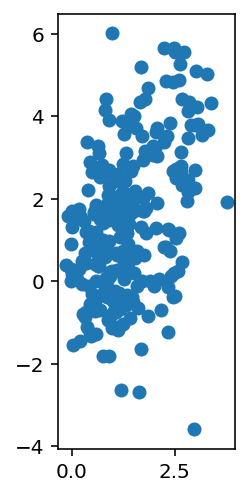

In [85]:
y_preds  = vmap(partial(model, best_param))(X_test)
plt.scatter(y_preds.squeeze(), y_test.squeeze())
plt.gca().set_aspect("equal")

In [81]:
from drosha_gnn.training import mse

mse(y_test, y_preds)

DeviceArray(2.6667647, dtype=float32)

In [78]:
best_idx

DeviceArray(81, dtype=int32)

In [77]:
# import matplotlib.pyplot as plt
# plt.plot(losses_train)
# plt.plot(test_losses)